In [18]:
import torch
import torch.nn as nn
import copy
from PIL import Image
import torch.nn.functional as F
import numpy as np
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib.pyplot as plt
import timm
import warnings
img_size = 512 if torch.cuda.is_available() else 128 
import torchvision.transforms as transforms
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [20]:
transformation =transforms.Compose([
    transforms.Resize([img_size,img_size]),
    transforms.ToTensor()
])

def img_loader(img_path):
  img = Image.open(img_path)
  img = (transformation(img)).unsqueeze(0)
  return img.to(device, torch.float)
# update style and content image
img=img_loader("/kaggle/input/hgcvmbm/dancing.jpg")

In [21]:
def form_gram_matrix(f_map):
    a,b,c,d = f_map.size()
    mod_f_map = f_map.view(a*b,c*d)
    g_matrix = torch.matmul(mod_f_map, mod_f_map.T)
    return g_matrix/(a*b*c*d)

In [22]:
class ContentLoss(nn.Module):
  def __init__(self, f_map):
    super().__init__()
    self.f_map = f_map.detach()
#     self.loss=None
  def forward(self, input):
    self.loss = F.mse_loss(input, self.f_map)
    return input
class StyleLoss(nn.Module):
  def __init__(self, f_map):
    super().__init__()
    self.f_map = f_map
    self.g_mat = form_gram_matrix(f_map).detach()
  def forward(self, input):
    G=form_gram_matrix(input)
    self.loss = F.mse_loss(G,(self.g_mat))
    return input

In [23]:
model = timm.create_model("vgg19", pretrained = True)
model=model.eval()

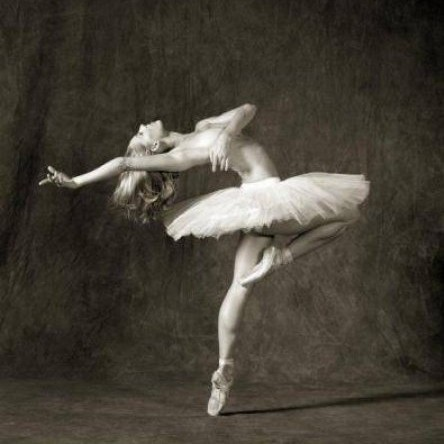

In [24]:
img=Image.open("/kaggle/input/hgcvmbm/dancing.jpg")
# img.size
img

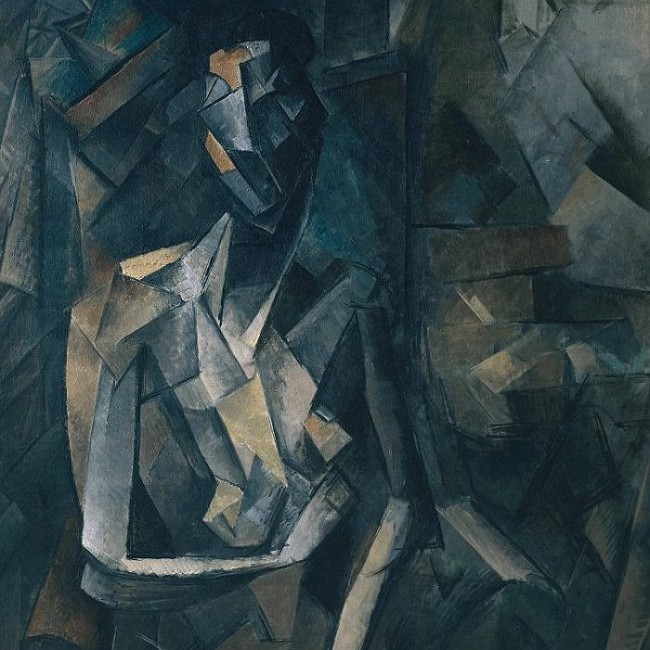

In [25]:
img2=Image.open("/kaggle/input/hgcvmbm/picasso.jpg")
img2

In [26]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [27]:
input_image_content=img_loader("/kaggle/input/hgcvmbm/dancing.jpg")
input_image_style=img_loader("/kaggle/input/hgcvmbm/picasso.jpg")
input_image_style
# assert input_image_style.size() == input_image_content.size(), \
#     "we need to import style and content images of the same size"

tensor([[[[0.1882, 0.1608, 0.1490,  ..., 0.3843, 0.3647, 0.3725],
          [0.1529, 0.1412, 0.1333,  ..., 0.3647, 0.3608, 0.3725],
          [0.1373, 0.1490, 0.1490,  ..., 0.3882, 0.3725, 0.3725],
          ...,
          [0.1451, 0.1608, 0.1647,  ..., 0.1333, 0.1373, 0.1373],
          [0.1451, 0.1647, 0.1725,  ..., 0.1294, 0.1294, 0.1255],
          [0.1490, 0.1765, 0.1804,  ..., 0.1294, 0.1176, 0.1137]],

         [[0.2667, 0.2392, 0.2275,  ..., 0.4157, 0.3961, 0.4039],
          [0.2314, 0.2196, 0.2118,  ..., 0.3961, 0.3882, 0.4000],
          [0.2157, 0.2275, 0.2275,  ..., 0.4196, 0.4000, 0.3961],
          ...,
          [0.2157, 0.2314, 0.2353,  ..., 0.1882, 0.1922, 0.1922],
          [0.2078, 0.2314, 0.2353,  ..., 0.1922, 0.1882, 0.1843],
          [0.2078, 0.2353, 0.2392,  ..., 0.1922, 0.1804, 0.1765]],

         [[0.2941, 0.2706, 0.2627,  ..., 0.3725, 0.3529, 0.3608],
          [0.2588, 0.2510, 0.2471,  ..., 0.3529, 0.3451, 0.3569],
          [0.2431, 0.2588, 0.2627,  ..., 0

In [28]:
input_image_content

tensor([[[[0.1725, 0.1765, 0.1804,  ..., 0.0275, 0.0235, 0.0157],
          [0.1804, 0.1765, 0.1765,  ..., 0.0353, 0.0314, 0.0235],
          [0.1804, 0.1725, 0.1686,  ..., 0.0353, 0.0314, 0.0275],
          ...,
          [0.2941, 0.2863, 0.2784,  ..., 0.2118, 0.2078, 0.2000],
          [0.2863, 0.2784, 0.2745,  ..., 0.2118, 0.2118, 0.2039],
          [0.2824, 0.2784, 0.2745,  ..., 0.2157, 0.2118, 0.2039]],

         [[0.1529, 0.1569, 0.1608,  ..., 0.0235, 0.0196, 0.0118],
          [0.1608, 0.1569, 0.1569,  ..., 0.0314, 0.0275, 0.0196],
          [0.1608, 0.1529, 0.1490,  ..., 0.0314, 0.0275, 0.0235],
          ...,
          [0.2784, 0.2706, 0.2627,  ..., 0.1961, 0.1922, 0.1843],
          [0.2706, 0.2627, 0.2588,  ..., 0.1961, 0.1961, 0.1882],
          [0.2667, 0.2627, 0.2588,  ..., 0.2000, 0.1961, 0.1882]],

         [[0.1294, 0.1333, 0.1373,  ..., 0.0157, 0.0118, 0.0039],
          [0.1373, 0.1333, 0.1333,  ..., 0.0235, 0.0196, 0.0118],
          [0.1373, 0.1294, 0.1255,  ..., 0

In [29]:
normailsation=Normalization(cnn_normalization_mean,cnn_normalization_std)
NST_model = nn.Sequential(normailsation)
conv_count = 0
relu_count = 0
maxpool_count = 0
batchnorm_count = 0
content_loss_count = 0
style_loss_count = 0
content_loss_layers = ['conv_4']
style_loss_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

style_feature_maps=[]
content_feature_maps=[]
for  child in model.features.children():
  if(isinstance(child, nn.Conv2d)):
    conv_count = conv_count + 1
    name = f"conv_{conv_count}"
    
  if(isinstance(child, nn.ReLU)):
    relu_count = relu_count + 1
    name = f"relu_{relu_count}"
    child = nn.ReLU(inplace = False)
    
  if(isinstance(child, nn.MaxPool2d)):
    maxpool_count = maxpool_count + 1
    name = f"maxpool_{maxpool_count}"

  NST_model.add_module(name, child)
  if  name in content_loss_layers:
    content_loss_count = content_loss_count + 1
    f=NST_model(input_image_content).detach()
    sy=ContentLoss(NST_model(input_image_content).detach())
    NST_model.add_module(f"content_loss_{content_loss_count}",sy)
    content_feature_maps.append(sy)
    print("content")

  if  name in style_loss_layers:
    style_loss_count = style_loss_count + 1
    print("style")
    f = NST_model(input_image_style).detach()
    sy = StyleLoss(f)
    NST_model.add_module(f"style_loss_{style_loss_count}", sy)
    style_feature_maps.append(sy)
for i in range(len(NST_model) - 1, -1, -1):
        if isinstance(NST_model[i], ContentLoss) or isinstance(NST_model[i], StyleLoss):
            break

NST_model = NST_model[:(i + 1)]

style
style
style
content
style
style


In [30]:
noise_img = input_image_content.clone()
noise_img

tensor([[[[0.1725, 0.1765, 0.1804,  ..., 0.0275, 0.0235, 0.0157],
          [0.1804, 0.1765, 0.1765,  ..., 0.0353, 0.0314, 0.0235],
          [0.1804, 0.1725, 0.1686,  ..., 0.0353, 0.0314, 0.0275],
          ...,
          [0.2941, 0.2863, 0.2784,  ..., 0.2118, 0.2078, 0.2000],
          [0.2863, 0.2784, 0.2745,  ..., 0.2118, 0.2118, 0.2039],
          [0.2824, 0.2784, 0.2745,  ..., 0.2157, 0.2118, 0.2039]],

         [[0.1529, 0.1569, 0.1608,  ..., 0.0235, 0.0196, 0.0118],
          [0.1608, 0.1569, 0.1569,  ..., 0.0314, 0.0275, 0.0196],
          [0.1608, 0.1529, 0.1490,  ..., 0.0314, 0.0275, 0.0235],
          ...,
          [0.2784, 0.2706, 0.2627,  ..., 0.1961, 0.1922, 0.1843],
          [0.2706, 0.2627, 0.2588,  ..., 0.1961, 0.1961, 0.1882],
          [0.2667, 0.2627, 0.2588,  ..., 0.2000, 0.1961, 0.1882]],

         [[0.1294, 0.1333, 0.1373,  ..., 0.0157, 0.0118, 0.0039],
          [0.1373, 0.1333, 0.1333,  ..., 0.0235, 0.0196, 0.0118],
          [0.1373, 0.1294, 0.1255,  ..., 0

In [31]:
def lbfgs_optimizer(input_image):
    p=torch.optim.LBFGS([input_image])
    return p


In [32]:
# print(style_feature_maps[0].forward())

In [33]:
NST_model

Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_1): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (maxpool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)

In [39]:
noise_img.requires_grad_(True)
NST_model.eval()
NST_model.requires_grad_(False)
optimizer=lbfgs_optimizer(noise_img)
epochs=100
for i in range(epochs):
    def closure():
        with torch.no_grad():
            noise_img.clamp_(0, 1)
        style_loss = torch.tensor(0.0, device=noise_img.device)  # Initialize style loss as a tensor
        content_loss = torch.tensor(0.0, device=noise_img.device)
        optimizer.zero_grad()
        NST_model(noise_img)
        for sl in style_feature_maps:
            style_loss=style_loss+sl.loss
#             print(sl.loss)
        for sl in content_feature_maps:
            content_loss=content_loss+sl.loss
        loss=style_loss*(1000000)+content_loss*(1)
#         print(loss)
        loss.backward()
        return loss
    optimizer.step(closure)
with torch.no_grad():
        noise_img.clamp_(0, 1)

In [40]:
unloader = transforms.ToPILImage()  # reconvert into PIL image
plt.ion()
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


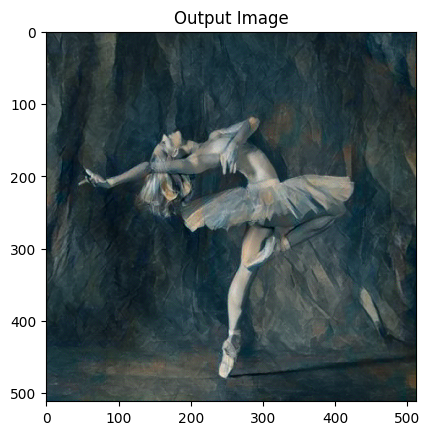

In [41]:
plt.figure()
imshow(noise_img, title='Output Image')